In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import numpy as np
import pandas as pd
from pathlib import Path

In [ ]:
import pandas as pd
import spacy
from typing import List

# english model
nlp = spacy.load("en_core_web_sm")

In [ ]:
def score_richness(originals: List[str], enhanced: List[str]) -> pd.DataFrame:
    records = []
    for orig_text, enh_text in zip(originals, enhanced):
        doc_o = nlp(orig_text)
        doc_e = nlp(enh_text)

        # get alphabetic tokens
        tokens_o = [t for t in doc_o if t.is_alpha]
        tokens_e = [t for t in doc_e if t.is_alpha]

        # lexical diversity (TTR)
        ttr_o = len(set([t.text.lower() for t in tokens_o])) / len(tokens_o) if tokens_o else 0
        ttr_e = len(set([t.text.lower() for t in tokens_e])) / len(tokens_e) if tokens_e else 0

        # lexical density (content words/total)
        content_pos = {"NOUN", "VERB", "ADJ", "ADV", "PROPN"}
        density_o = sum(1 for t in tokens_o if t.pos_ in content_pos) / len(tokens_o) if tokens_o else 0
        density_e = sum(1 for t in tokens_e if t.pos_ in content_pos) / len(tokens_e) if tokens_e else 0

        # POS enrichment ratios
        adj_o = sum(1 for t in tokens_o if t.pos_ == "ADJ") / len(tokens_o) if tokens_o else 0
        adj_e = sum(1 for t in tokens_e if t.pos_ == "ADJ") / len(tokens_e) if tokens_e else 0
        noun_o = sum(1 for t in tokens_o if t.pos_ in {"NOUN", "PROPN"}) / len(tokens_o) if tokens_o else 0
        noun_e = sum(1 for t in tokens_e if t.pos_ in {"NOUN", "PROPN"}) / len(tokens_e) if tokens_e else 0
        verb_o = sum(1 for t in tokens_o if t.pos_ == "VERB") / len(tokens_o) if tokens_o else 0
        verb_e = sum(1 for t in tokens_e if t.pos_ == "VERB") / len(tokens_e) if tokens_e else 0

        # NER counts
        ner_o = len(doc_o.ents)
        ner_e = len(doc_e.ents)

        records.append({
            "ttr_orig": ttr_o,
            "ttr_enh": ttr_e,
            "ttr_diff": ttr_e - ttr_o,
            "density_orig": density_o,
            "density_enh": density_e,
            "density_diff": density_e - density_o,
            "adj_ratio_orig": adj_o,
            "adj_ratio_enh": adj_e,
            "adj_ratio_diff": adj_e - adj_o,
            "noun_ratio_orig": noun_o,
            "noun_ratio_enh": noun_e,
            "noun_ratio_diff": noun_e - noun_o,
            "verb_ratio_orig": verb_o,
            "verb_ratio_enh": verb_e,
            "verb_ratio_diff": verb_e - verb_o,
            "ner_orig": ner_o,
            "ner_enh": ner_e,
            "ner_diff": ner_e - ner_o,
        })

    return pd.DataFrame(records)


In [ ]:
def collect_richness_scores(base_path: str, model_dirs: list[str]) -> pd.DataFrame:
    records = []
    base = Path(base_path)
    orig_folder = base / "original"

    for model in model_dirs:
        if model == "original":
            continue  # skip comparing original to original
        mod_folder = base / model
        txts = sorted(
            [p for p in mod_folder.glob("*.txt") if p.stem.isdigit()],
            key=lambda p: int(p.stem)
        )
        print(f"{model}: found {len(txts)} prompts")

        for p in txts:
            idx = int(p.stem)
            orig_text = (orig_folder / f"{idx}.txt").read_text(encoding="utf-8")
            enh_text  = p.read_text(encoding="utf-8")

            # call function  ################################################### here
            df_one = score_richness(
                originals      = [orig_text],
                enhanced       = [enh_text]
            )

            # add model/index by converting to dic
            row = df_one.iloc[0].to_dict()
            row.update({
                "model": model,
                "index": idx
            })
            records.append(row)

    # build a df with every metric and aggregate
    return (
        pd.DataFrame.from_records(records)
          .sort_values(["model","index"], ignore_index=True)
    )


# run
base_dir = "/content/drive/MyDrive/NLP_proj/text_data"
models   = ["BART_gen","deepseek_gen","QWEN_generated","t5_gen"]

df_scores = collect_richness_scores(base_dir, models)
print(df_scores.head())

# save
out_path = "/content/drive/MyDrive/NLP_proj/richness_scores_all_models.csv"
df_scores.to_csv(out_path, index=False)
print("Saved to", out_path)

BART_gen: found 200 prompts
deepseek_gen: found 200 prompts
QWEN_generated: found 200 prompts
t5_gen: found 200 prompts
   ttr_orig   ttr_enh  ttr_diff  density_orig  density_enh  density_diff  \
0  0.800000  0.684211 -0.115789      0.600000     0.631579      0.031579   
1  0.777778  0.590361 -0.187416      0.555556     0.493976     -0.061580   
2  0.864865  0.615385 -0.249480      0.648649     0.551282     -0.097367   
3  0.920000  0.452381 -0.467619      0.680000     0.595238     -0.084762   
4  0.827586  0.954545  0.126959      0.586207     0.954545      0.368339   

   adj_ratio_orig  adj_ratio_enh  adj_ratio_diff  noun_ratio_orig  \
0        0.171429       0.184211        0.012782         0.285714   
1        0.166667       0.120482       -0.046185         0.277778   
2        0.135135       0.141026        0.005891         0.297297   
3        0.240000       0.190476       -0.049524         0.280000   
4        0.103448       0.318182        0.214734         0.310345   

   noun_

Simple visualisation:

In [ ]:
# weighte sun
diff_cols = ['ttr_diff', 'density_diff','adj_ratio_diff',
             'noun_ratio_diff', 'verb_ratio_diff','ner_diff']

# [0, 1] normalisation
for col in diff_cols:
    mn, mx = df_scores[col].min(), df_scores[col].max()
    df_scores[f'{col}_norm'] = (df_scores[col] - mn) / (mx - mn) if mx > mn else 0.0

# get temp richness score
norm_cols = [f"{c}_norm" for c in diff_cols]
df_scores['richness_score'] = df_scores[norm_cols].mean(axis=1)

In [ ]:
import matplotlib.pyplot as plt

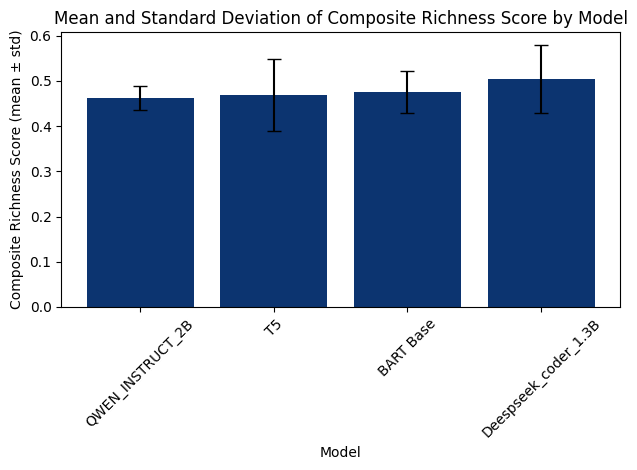

In [ ]:
model_stats = df_scores.groupby('model')['richness_score'].agg(['mean', 'std']).reset_index()

# display rename
name_map = {"BART_gen": "BART Base",
            "deepseek_gen": "Deespseek_coder_1.3B",
            "QWEN_generated": "QWEN_INSTRUCT_2B",
            "t5_gen": "T5"}
model_stats['model_name'] = model_stats['model'].map(name_map)

# sort
model_stats = model_stats.sort_values('mean')

# plot
plt.figure()
plt.bar(
    model_stats['model_name'],
    model_stats['mean'],
    yerr=model_stats['std'],
    capsize=5,
    color='#0c3470'
)
plt.xlabel('Model')
plt.ylabel('Composite Richness Score (mean ± std)')
plt.title('Mean and Standard Deviation of Composite Richness Score by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()